In [ ]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from lit_modules.densenet_lit import DenseNetLit
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger

L.seed_everything(42)
torch.set_float32_matmul_precision("medium")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.cuda.empty_cache()

Seed set to 42


Using device: cuda


In [ ]:
IMAGE_SIZE = 32
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
# source: https://pytorch.org/vision/stable/transforms.html
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)
transforms_test = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)
whole_dataset = datasets.EuroSAT(
    root="./data", download=True, transform=transforms_train
)
N = len(whole_dataset)
num_val = int(0.2 * N)
num_test = int(0.2 * N)
num_train = N - num_val - num_test
all_indices = list(range(N))
all_indices = torch.randperm(N).tolist()
indices_val = torch.randperm(N)[:num_val]
indices_test = torch.randperm(N)[:num_test]
train_indices = all_indices[:num_train]
val_indices = all_indices[num_train : num_train + num_val]
test_indices = all_indices[num_train + num_val : num_train + num_val + num_test]

train_dataset = torch.utils.data.Subset(whole_dataset, train_indices)
validation_dataset = torch.utils.data.Subset(whole_dataset, val_indices)
test_dataset = torch.utils.data.Subset(whole_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=512,
    num_workers=30,
    persistent_workers=True,
    shuffle=True,
)
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=512, num_workers=30, persistent_workers=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=512, num_workers=30, persistent_workers=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6719378..2.0591094].


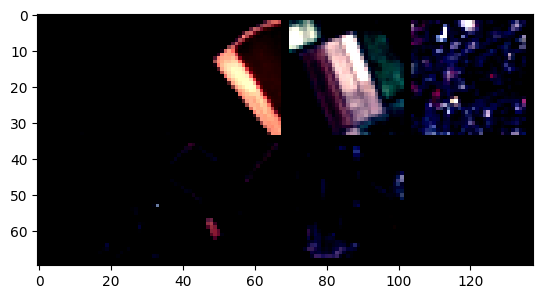

In [9]:
import matplotlib.pyplot as plt
import numpy as np


def show_img(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


images, labels = next(iter(train_loader))
show_img(torchvision.utils.make_grid(images[:8], nrow=4, padding=2))

In [10]:
class DataModule(L.LightningDataModule):
    def __init__(self, train_loader, validation_loader, test_loader):
        super().__init__()
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.test_loader = test_loader

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.validation_loader

    def test_dataloader(self):
        return self.test_loader


data = DataModule(train_loader, validation_loader, test_loader)
hyperparameters = {
    "depth": 40,
    "first_output": 16,
    "growth_rate": 12,
    "dropout": 0.2,
}
model = DenseNetLit(hyperparameters=hyperparameters)
logger = MLFlowLogger(experiment_name="Densenet-EuroSat", save_dir="mlruns")
trainer = L.Trainer(
    max_epochs=50,
    logger=logger,
    callbacks=[
        ModelCheckpoint(
            monitor="val_acc",
            mode="max",
            dirpath="checkpoints/densenet-eurosat",
            filename="{epoch:02d}-{val_acc:.3f}",
        )
    ],
    precision="16-mixed",
    num_sanity_val_steps=0,
)
trainer.fit(model, datamodule=data)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | DenseNet         | 1.0 M  | train
1 | loss_fn       | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.079     Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s] 

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 7.63 GiB of which 84.81 MiB is free. Process 7416 has 1.40 GiB memory in use. Process 10037 has 186.00 MiB memory in use. Including non-PyTorch memory, this process has 5.03 GiB memory in use. Of the allocated memory 4.76 GiB is allocated by PyTorch, and 128.60 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
best_ckpt = trainer.checkpoint_callback.best_model_path
trainer.test(model, datamodule=data, ckpt_path=best_ckpt)
None